# Baseline de Clasificación — Boletín Oficial CABA (TF‑IDF + 4 algoritmos)

**Fecha:** 2025-11-09

Este notebook entrena y evalúa 4 modelos clásicos sobre fragmentos del Boletín Oficial:
- Regresión Logística (LR)
- SVM lineal (con calibración para probabilidades)
- Naive Bayes (ComplementNB)
- Random Forest

**Objetivo operativo:** priorizar **sensibilidad (recall)** por sobre precisión.  
**Selección de hiperparámetros:** validación cruzada en *train*.  
**Calibración de umbral:** en *val* (t_F2 y t_R@X).  
**Métrica final:** en *test* (modelo y umbral fijos).

> Requisitos mínimos en los CSV: columna de texto (`fragmento` o `fragmento_final`) y etiqueta binaria `label` (0/1).

### Celda 1 — Configuración de rutas y parámetros

**Objetivo.** Definir rutas de entrada/salida, crear carpetas y fijar parámetros globales.

* Setea `BASE`, paths de `CSV_TRAIN`, `CSV_VAL`, `CSV_TEST`.
* Crea directorios de `models/`, `metrics/`, `plots/`, `artifacts/`.
* Define `RECALL_TARGET` (umbral deseado de sensibilidad) y `RANDOM_STATE` (reproducibilidad).

**Salida.** Sin archivos; solo prepara el entorno.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# === Configurar estas rutas antes de ejecutar en Colab ===
BASE = "/content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml"

CSV_TRAIN = f"{BASE}/data/labels/dataset_train_final.csv"
CSV_VAL   = f"{BASE}/data/labels/dataset_val_final.csv"
CSV_TEST  = f"{BASE}/data/labels/dataset_test_final.csv"

OUT_MODELS  = f"{BASE}/models/baseline"
OUT_METRICS = f"{BASE}/metrics/baseline"
OUT_PLOTS   = f"{BASE}/plots/baseline"
OUT_MISC    = f"{BASE}/artifacts/baseline"

RECALL_TARGET = 0.80  # para t_R@X (ej.: 0.80 = 80%)
RANDOM_STATE  = 2025

import os
for d in [OUT_MODELS, OUT_METRICS, OUT_PLOTS, OUT_MISC]:
    os.makedirs(d, exist_ok=True)

print("Rutas OK ✅")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rutas OK ✅


### Celda 2 — Carga de datos y chequeos básicos

**Objetivo.** Cargar los CSV, validar formato y limpiar duplicados exactos.

* Detecta la columna de texto (`fragmento` / `fragmento_final` / `texto`).
* Valida que exista `label` y la convierte a binaria 0/1.
* Elimina filas con texto vacío y duplicados exactos por texto.
* Muestra tamaños y cantidad de positivos por split.

**Salida.** DataFrames `train_df`, `val_df`, `test_df` listos para modelado.

In [3]:
import pandas as pd, numpy as np, re

def read_csv_any(path):
    """Lee CSV con separador autodetectado y UTF-8 con BOM si existiera."""
    return pd.read_csv(path, dtype=str, keep_default_na=False, encoding="utf-8-sig",
                       sep=None, engine="python")

def pick_text_column(df):
    """Elige la columna de texto. Preferencia: 'fragmento' -> 'fragmento_final' -> 'texto'."""
    for c in ["fragmento", "fragmento_final", "texto"]:
        if c in df.columns:
            return c
    raise ValueError("No se encontró una columna de texto entre {'fragmento','fragmento_final','texto'}.")

def coerce_label(s):
    """Convierte etiquetas a 0/1 enteros (admite '0','1', 0,1, 'False','True')."""
    m = s.astype(str).str.strip().str.lower().map({"1":1,"0":0,"true":1,"false":0})
    if m.isna().any():
        try:
            m = s.astype(int)
        except Exception:
            raise ValueError("La columna 'label' debe ser binaria (0/1).")
    return m.astype(int)

def load_split(path):
    df = read_csv_any(path)
    text_col = pick_text_column(df)
    if 'label' not in df.columns:
        raise ValueError("Se requiere columna 'label' (0/1).")
    df['label'] = coerce_label(df['label'])
    df = df[df[text_col].astype(str).str.strip().ne("")].copy()
    before = len(df)
    df = df.drop_duplicates(subset=[text_col])
    if len(df) < before:
        print(f"Deduplicados exactos por texto: {before - len(df)}")
    return df, text_col

train_df, TEXT_COL = load_split(CSV_TRAIN)
val_df,   _        = load_split(CSV_VAL)
test_df,  _        = load_split(CSV_TEST)

print(f"Train: {train_df.shape}  | Positivos: {train_df['label'].sum()}")
print(f"Val:   {val_df.shape}    | Positivos: {val_df['label'].sum()}")
print(f"Test:  {test_df.shape}   | Positivos: {test_df['label'].sum()}")
print(f"Columna de texto: {TEXT_COL}")

Deduplicados exactos por texto: 14
Deduplicados exactos por texto: 5
Deduplicados exactos por texto: 40
Train: (2355, 13)  | Positivos: 714
Val:   (495, 9)    | Positivos: 82
Test:  (1160, 9)   | Positivos: 44
Columna de texto: fragmento


### Celda 3 — Pipelines con TF-IDF + GridSearchCV (CV **sin fuga**)

**Objetivo.** Seleccionar hiperparámetros por **validación cruzada** con TF-IDF dentro del `Pipeline` (evita fuga).

* Define 4 pipelines:

  * **LR**: `TfidfVectorizer` → `LogisticRegression` (L2, `class_weight=balanced`).
  * **SVM**: `TfidfVectorizer` → `LinearSVC` (`class_weight=balanced`).
  * **NB**: `TfidfVectorizer` → `ComplementNB`.
  * **RF**: `TfidfVectorizer` → **SVD (LSA, 300 comp.)** → `RandomForest` (para reducir dimensión).
* Corre **GridSearchCV** (5-fold estratificado) con **dos métricas**:

  * `average_precision` (**AUC-PR**) y `roc_auc` (**AUC-ROC**).
  * `refit="ap"` → el mejor se elige por **AUC-PR medio**.
* Guarda **`metrics/baseline/cv_results_pipeline.csv`** (tabla completa).
* Deja en memoria `best_estimators` (mejor pipeline por modelo).

**Salida.** Archivo de resultados de CV + pipelines óptimos en `best_estimators`.

In [4]:
# === 3P) Pipelines con TF-IDF adentro + GridSearchCV multi-métrica (AP y ROC) ===
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier

import numpy as np, pandas as pd

# Estratificada, reproducible
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# TF-IDF base (fijamos HP del vectorizador para evitar grids enormes)
tfidf_params = dict(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    max_features=100_000
)

# Pipelines por modelo
pipe_lr  = Pipeline([("tfidf", TfidfVectorizer(**tfidf_params)),
                     ("clf",   LogisticRegression(penalty="l2", class_weight="balanced",
                                                  max_iter=1000, solver="liblinear"))])

pipe_svm = Pipeline([("tfidf", TfidfVectorizer(**tfidf_params)),
                     ("clf",   LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))])

pipe_nb  = Pipeline([("tfidf", TfidfVectorizer(**tfidf_params)),
                     ("clf",   ComplementNB())])

# Para RF comprimimos con SVD (LSA) para evitar explotar memoria con TF-IDF esparso
pipe_rf  = Pipeline([("tfidf", TfidfVectorizer(**tfidf_params)),
                     ("svd",   TruncatedSVD(n_components=300, random_state=RANDOM_STATE)),
                     ("clf",   RandomForestClassifier(n_estimators=400,
                                                     class_weight="balanced_subsample",
                                                     random_state=RANDOM_STATE,
                                                     n_jobs=-1))])

# Grids pequeños (solo del clasificador)
grids = {
    "LR":  (pipe_lr,  {"clf__C":[0.2, 1.0, 5.0]}),
    "SVM": (pipe_svm, {"clf__C":[0.5, 1.0, 2.0]}),
    "NB":  (pipe_nb,  {"clf__alpha":[0.5, 1.0, 2.0]}),
    "RF":  (pipe_rf,  {"clf__max_depth":[None, 20],
                       "clf__max_features":["sqrt", 0.5],
                       "clf__min_samples_leaf":[1, 5]}),
}

# Scoring multi-métrica: AP = average_precision (AUC-PR), ROC = AUC-ROC
scoring = {"ap":"average_precision", "roc":"roc_auc"}

cv_rows = []
best_estimators = {}

Xtr = train_df[TEXT_COL].values
ytr = train_df["label"].values

for name, (pipe, grid) in grids.items():
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring=scoring,           # AP y ROC
        refit="ap",                # elige y reentrena por AP (AUC-PR)
        cv=skf,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(Xtr, ytr)
    best_estimators[name] = gs.best_estimator_

    res = pd.DataFrame(gs.cv_results_)
    res["model"] = name
    # columnas amigables
    keep = ["model","rank_test_ap","mean_test_ap","std_test_ap","mean_test_roc","std_test_roc","params"]
    cv_rows.append(res[keep].sort_values("rank_test_ap"))

cv_table = pd.concat(cv_rows, ignore_index=True)
cv_table.sort_values(["model","rank_test_ap"], inplace=True)
cv_table.to_csv(f"{OUT_METRICS}/cv_results_pipeline.csv", index=False, encoding="utf-8-sig")
cv_table.head(12)

,model,rank_test_ap,mean_test_ap,std_test_ap,mean_test_roc,std_test_roc,params
0,LR,1,0.988716,0.004010,0.994944,0.002027,{'clf__C': 5.0}
1,LR,2,0.986731,0.004128,0.993894,0.002235,{'clf__C': 1.0}
2,LR,3,0.981451,0.005155,0.991129,0.003025,{'clf__C': 0.2}
6,NB,1,0.979392,0.006019,0.990497,0.003067,{'clf__alpha': 1.0}
7,NB,2,0.978221,0.007649,0.991026,0.002971,{'clf__alpha': 0.5}
8,NB,3,0.977748,0.005285,0.988812,0.003225,{'clf__alpha': 2.0}
9,RF,1,0.978186,0.006681,0.990352,0.003458,"{'clf__max_depth': None, 'clf__max_features': ..."
10,RF,2,0.978160,0.006813,0.990318,0.003521,"{'clf__max_depth': 20, 'clf__max_features': 's..."
11,RF,3,0.976063,0.008206,0.988727,0.004682,"{'clf__max_depth': None, 'clf__max_features': ..."
12,RF,4,0.976048,0.008138,0.988718,0.004646,"{'clf__max_depth': 20, 'clf__max_features': 's..."


### Celda 4 — Reentrenar en *full train* y preparar *scores* (val/test)

**Objetivo.** Reentrenar cada **pipeline ganador** con **todo `train`** y generar **scores** para *val* y *test*.

* Ajusta `best_estimators[name]` con **todo `train`**.
* Calcula `scores_val[name]` y `scores_test[name]` (probabilidades o `decision_function`).
* Reporta **AP y ROC en val** (chequeo rápido).

**Salida.** Diccionarios `final_models`, `scores_val`, `scores_test` (insumos para umbrales y test).

In [5]:
# === 4P) Reentrenar en FULL TRAIN y generar scores para val/test (sin fuga) ===
from sklearn.metrics import roc_auc_score, average_precision_score

final_models = {}
scores_val, scores_test = {}, {}

X_val_txt  = val_df[TEXT_COL].values
y_val      = val_df["label"].values
X_test_txt = test_df[TEXT_COL].values
y_test     = test_df["label"].values

for name, est in best_estimators.items():
    # Reentrena automáticamente en FULL TRAIN (el pipeline "refit" ya está con los mejores HP)
    est.fit(train_df[TEXT_COL].values, train_df["label"].values)
    final_models[name] = est

    # Obtener scores (probabilidades si existen; si es SVM -> decision_function)
    if hasattr(est.named_steps["clf"], "predict_proba"):
        s_val  = est.predict_proba(X_val_txt)[:,1]
        s_test = est.predict_proba(X_test_txt)[:,1]
    elif hasattr(est.named_steps["clf"], "decision_function"):
        s_val  = est.decision_function(X_val_txt)
        s_test = est.decision_function(X_test_txt)
    else:
        # fallback (no ideal): usar predicción binaria como score
        s_val  = est.predict(X_val_txt)
        s_test = est.predict(X_test_txt)

    scores_val[name]  = s_val
    scores_test[name] = s_test

# Mini chequeo rápido
for name in scores_val:
    ap_val  = average_precision_score(y_val, scores_val[name])
    roc_val = roc_auc_score(y_val, scores_val[name])
    print(f"{name}: VAL AP={ap_val:.3f} | ROC={roc_val:.3f}")

print("Pipelines listos ✅  -> podés seguir con las celdas 6, 7 y 8 (umbrales, test y gráficos).")

LR: VAL AP=0.925 | ROC=0.980
SVM: VAL AP=0.924 | ROC=0.981
NB: VAL AP=0.926 | ROC=0.981
RF: VAL AP=0.903 | ROC=0.965
Pipelines listos ✅  -> podés seguir con las celdas 6, 7 y 8 (umbrales, test y gráficos).


### Celda 5 — Calibración de umbral en *val* (prioriza **recall**)

**Objetivo.** Convertir scores en etiquetas eligiendo umbrales que prioricen **sensibilidad**.

* Escanea umbrales y calcula:

  * **`t_F2`**: umbral que maximiza **F-beta** con β=2 (recall pesa doble).
  * **`t_R@X`**: primer umbral con **Recall ≥ `RECALL_TARGET`** (si no se alcanza, usa el mejor `t_F2`).
* Guarda **`artifacts/baseline/thresholds_val.csv`** con ambos umbrales por modelo.

**Salida.** Diccionario `thresholds` con `t_F2` y `t_R@X` para cada modelo.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np, pandas as pd

def scan_thresholds(y_true, scores, recall_target=0.80):
    thr = np.unique(scores)[::-1]
    best_f2 = {"thr":0.5, "f2":-1, "p":0, "r":0}
    best_r  = {"thr":0.5, "p":0, "r":0}
    beta2 = 2**2

    for t in thr:
        y_hat = (scores >= t).astype(int)
        p,r,f1,_ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        f2 = (1+beta2) * (p*r) / (beta2*p + r) if (beta2*p + r) > 0 else 0.0
        if f2 > best_f2["f2"]:
            best_f2 = {"thr":float(t), "f2":float(f2), "p":float(p), "r":float(r)}
        if r >= recall_target:
            if r > best_r["r"] or (r == best_r["r"] and p > best_r["p"]):
                best_r = {"thr":float(t), "p":float(p), "r":float(r)}
    if best_r["r"] < recall_target:
        best_r = {"thr":best_f2["thr"], "p":best_f2["p"], "r":best_f2["r"]}
    return best_f2, best_r

thresholds = {}
for name, s in scores_val.items():
    tF2, tR = scan_thresholds(y_val, s, recall_target=RECALL_TARGET)
    thresholds[name] = {"t_F2": tF2, "t_R@X": tR}

pd.DataFrame({k: {f"{kk}_{m}":v for kk,d in th.items() for m,v in d.items()} for k,th in thresholds.items()}).T\
  .to_csv(f"{OUT_MISC}/thresholds_val.csv", encoding="utf-8-sig")

thresholds

{'LR': {'t_F2': {'thr': 0.3118200251819146,
   'f2': 0.8639308855291578,
   'p': 0.5925925925925926,
   'r': 0.975609756097561},
  't_R@X': {'thr': 0.2101152808222684, 'p': 0.47126436781609193, 'r': 1.0}},
 'SVM': {'t_F2': {'thr': 0.01886892335306456,
   'f2': 0.8752997601918464,
   'p': 0.8202247191011236,
   'r': 0.8902439024390244},
  't_R@X': {'thr': -0.4470032141234468, 'p': 0.47126436781609193, 'r': 1.0}},
 'NB': {'t_F2': {'thr': 0.2652043670629612,
   'f2': 0.8653846153846154,
   'p': 0.8181818181818182,
   'r': 0.8780487804878049},
  't_R@X': {'thr': 0.08263673147210392, 'p': 0.5256410256410257, 'r': 1.0}},
 'RF': {'t_F2': {'thr': 0.28,
   'f2': 0.8444444444444446,
   'p': 0.6229508196721312,
   'r': 0.926829268292683},
  't_R@X': {'thr': 0.1425, 'p': 0.2867132867132867, 'r': 1.0}}}

### Celda 6 — Evaluación final en *test* + IC 95% (bootstrap)

**Objetivo.** Medir el desempeño final con **modelo y umbral ya fijados** en *val*.

* Calcula: **Precisión**, **Recall**, **F1**, **AUC-ROC**, **AUC-PR** y **matriz de confusión** (TP, FN, FP, TN), para **`t_F2`** y **`t_R@X`** de cada modelo.
* Estima **intervalos de confianza 95%** por **bootstrap estratificado** (1.000 remuestreos) para Precisión/Recall/F1.
* Guarda **`metrics/baseline/test_summary.csv`** con todas las métricas e IC

**Salida.** Tabla de métricas finales en test (con IC).


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, average_precision_score
import numpy as np, pandas as pd

rng = np.random.default_rng(RANDOM_STATE)

def metrics_at(y_true, scores, thr):
    y_hat = (scores >= thr).astype(int)
    p,r,f1,_ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
    cm = confusion_matrix(y_true, y_hat, labels=[1,0])
    tp, fn, fp, tn = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    return {
        "precision": float(p),
        "recall": float(r),
        "f1": float(f1),
        "tp": int(tp), "fn": int(fn), "fp": int(fp), "tn": int(tn),
        "auc_roc": float(roc_auc_score(y_true, scores)),
        "auc_pr": float(average_precision_score(y_true, scores))
    }

def bootstrap_ci(y_true, scores, thr, B=1000, stratified=True):
    y_true = np.asarray(y_true)
    scores = np.asarray(scores)
    pos_idx = np.where(y_true==1)[0]
    neg_idx = np.where(y_true==0)[0]
    vals = {"precision":[], "recall":[], "f1":[]}
    for _ in range(B):
        if stratified and len(pos_idx)>0 and len(neg_idx)>0:
            samp_pos = rng.choice(pos_idx, size=len(pos_idx), replace=True)
            samp_neg = rng.choice(neg_idx, size=len(neg_idx), replace=True)
            idx = np.concatenate([samp_pos, samp_neg])
        else:
            idx = rng.choice(np.arange(len(y_true)), size=len(y_true), replace=True)
        m = metrics_at(y_true[idx], scores[idx], thr)
        for k in vals: vals[k].append(m[k])
    ci = {}
    for k in vals:
        arr = np.array(vals[k])
        lo, hi = np.percentile(arr, [2.5, 97.5])
        ci[k] = (float(lo), float(hi))
    return ci

rows = []
for name, s in scores_test.items():
    for key in ["t_F2","t_R@X"]:
        thr = thresholds[name][key]["thr"]
        m = metrics_at(y_test, s, thr)
        ci = bootstrap_ci(y_test, s, thr, B=1000, stratified=True)
        rows.append({
            "model": name,
            "threshold": key,
            **m,
            "precision_ci95": f"[{ci['precision'][0]:.3f}, {ci['precision'][1]:.3f}]",
            "recall_ci95":    f"[{ci['recall'][0]:.3f}, {ci['recall'][1]:.3f}]",
            "f1_ci95":        f"[{ci['f1'][0]:.3f}, {ci['f1'][1]:.3f}]",
        })

test_summary = pd.DataFrame(rows).sort_values(["model","threshold"]).reset_index(drop=True)
test_summary.to_csv(f"{OUT_METRICS}/test_summary.csv", index=False, encoding="utf-8-sig")
test_summary

,model,threshold,precision,recall,f1,tp,fn,fp,tn,auc_roc,auc_pr,precision_ci95,recall_ci95,f1_ci95
0,LR,t_F2,0.267516,0.954545,0.417910,42,2,115,1001,0.983321,0.863788,"[0.235, 0.307]","[0.886, 1.000]","[0.374, 0.467]"
1,LR,t_R@X,0.181435,0.977273,0.306050,43,1,194,922,0.983321,0.863788,"[0.162, 0.202]","[0.932, 1.000]","[0.277, 0.335]"
2,NB,t_F2,0.484848,0.727273,0.581818,32,12,34,1082,0.968271,0.752815,"[0.390, 0.583]","[0.591, 0.864]","[0.477, 0.674]"
3,NB,t_R@X,0.205000,0.931818,0.336066,41,3,159,957,0.968271,0.752815,"[0.180, 0.232]","[0.841, 1.000]","[0.299, 0.374]"
4,RF,t_F2,0.295455,0.886364,0.443182,39,5,93,1023,0.968577,0.740813,"[0.252, 0.345]","[0.773, 0.977]","[0.387, 0.503]"
5,RF,t_R@X,0.098434,1.000000,0.179226,44,0,403,713,0.968577,0.740813,"[0.092, 0.106]","[1.000, 1.000]","[0.168, 0.191]"
6,SVM,t_F2,0.666667,0.863636,0.752475,38,6,19,1097,0.985561,0.880868,"[0.571, 0.774]","[0.750, 0.955]","[0.667, 0.828]"
7,SVM,t_R@X,0.180672,0.977273,0.304965,43,1,195,921,0.985561,0.880868,"[0.161, 0.205]","[0.932, 1.000]","[0.276, 0.339]"


### Celda 8 — Curvas ROC y Precisión-Recall (test)

**Objetivo.** Visualizar el trade-off de cada modelo en *test*.

* Dibuja y guarda:

  * **ROC**: TPR vs. FPR (con AUC-ROC).
  * **Precisión-Recall**: Precisión vs. Recall (con AP).
* Archivos: `plots/baseline/roc_test.png` y `plots/baseline/pr_test.png`.

**Salida.** Gráficos comparativos para el informe/presentación.

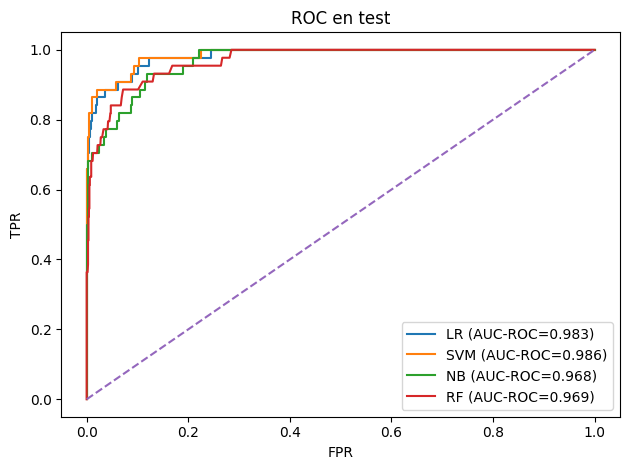

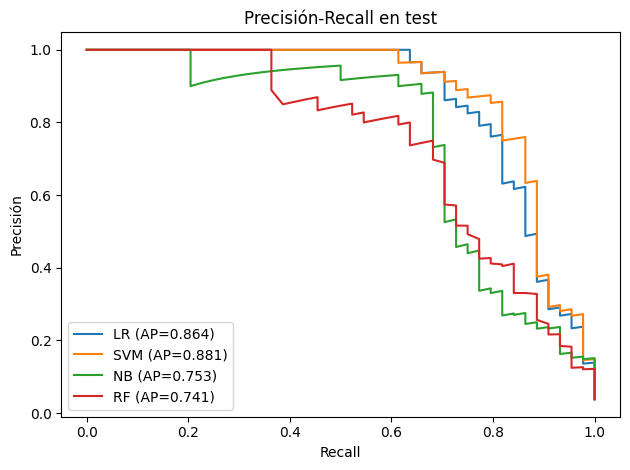

Gráficos guardados en: /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/plots/baseline


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# ROC
plt.figure()
for name, s in scores_test.items():
    fpr, tpr, _ = roc_curve(y_test, s)
    auc = roc_auc_score(y_test, s)
    plt.plot(fpr, tpr, label=f"{name} (AUC-ROC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC en test")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUT_PLOTS}/roc_test.png", dpi=150)
plt.show()

# PR
plt.figure()
for name, s in scores_test.items():
    prec, rec, _ = precision_recall_curve(y_test, s)
    ap = average_precision_score(y_test, s)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precisión")
plt.title("Precisión‑Recall en test")
plt.legend()
plt.tight_layout()
plt.savefig(f"{OUT_PLOTS}/pr_test.png", dpi=150)
plt.show()

print("Gráficos guardados en:", OUT_PLOTS)

### Celda 9 — Guarda el pipeline del mejor modelo

In [6]:
from joblib import dump
import os

from google.colab import drive
drive.mount('/content/drive')

# Carpeta donde querés guardar el modelo para la demo
MODEL_DIR = f"{BASE}/models/demo_svm"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "svm_tfidf_pipeline.joblib")

# OJO: usamos el pipeline FINAL reentrenado en todo train
svm_pipeline = final_models["SVM"]

dump(svm_pipeline, MODEL_PATH)
print("Modelo SVM+TF-IDF guardado en:", MODEL_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modelo SVM+TF-IDF guardado en: /content/drive/MyDrive/IA/Proyectos/Análisis Boletín Oficial/boletin-ml/models/demo_svm/svm_tfidf_pipeline.joblib
